# A Convolutional Neural Network ensemble model for Pneumonia Detection using chest X-ray images

This phase included the recreation and reimplementation of the research paper

#### Implemented by:
- Sahal Saeed
- Fardeen Farhat
- Zain Ul Wahab

## Importing Libraries

This section imports all the necessary libraries required for the model, data manipulation, and evaluation:

- **os**: Provides a way to interact with the operating system.
- **numpy**: Used for numerical operations.
- **seaborn**: For data visualization, especially statistical plots.
- **tensorflow**: The core deep learning library for building and training models.
- **matplotlib.cm**: For colormap handling in plots.
- **Counter**: A collection tool from Python's `collections` module to count occurrences.
- **pickle**: Used for dictionary and model saving
- **matplotlib.pyplot**: A plotting library to visualize results.
- **tensorflow.keras**: Includes layers, models, metrics, and backend for deep learning tasks.
- **sklearn.metrics**: For computing classification metrics like accuracy, precision, recall, F1 score, confusion matrix, and classification report.
- **ImageDataGenerator**: For real-time data augmentation during training.

In [39]:
import os
import pickle
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.cm as cm
from collections import Counter
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import models
from sklearn.metrics import f1_score
from tensorflow.keras import metrics
from sklearn.metrics import recall_score
from tensorflow.keras import backend as K
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Load Dataset & Analyze Class Distribution

In this section, we load the Chest X-ray dataset and analyze the distribution of images across the different categories (NORMAL and PNEUMONIA) for each dataset split (train, test, and validation). 

- **data_dir**: Specifies the path to the dataset.
- **splits**: A list of the dataset splits, i.e., 'train', 'test', and 'val'.
- **categories**: A list of the two categories: 'NORMAL' and 'PNEUMONIA'.
- The code loops through each split and category to count the number of images in each class and stores the results in a dictionary `data_distribution`.
- The distribution is visualized using **seaborn**'s barplot function, which shows the number of images per class for each split.

In [4]:
# Dataset path
data_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray'

In [5]:
# Count images in each category for train, test, val
splits = ['train', 'test', 'val']
categories = ['NORMAL', 'PNEUMONIA']
data_distribution = {}

for split in splits:
    data_distribution[split] = {}
    for category in categories:
        folder_path = os.path.join(data_dir, split, category)
        count = len(os.listdir(folder_path))
        data_distribution[split][category] = count

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


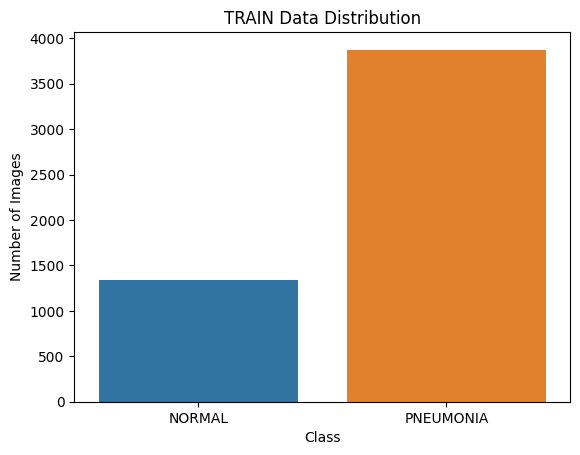

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


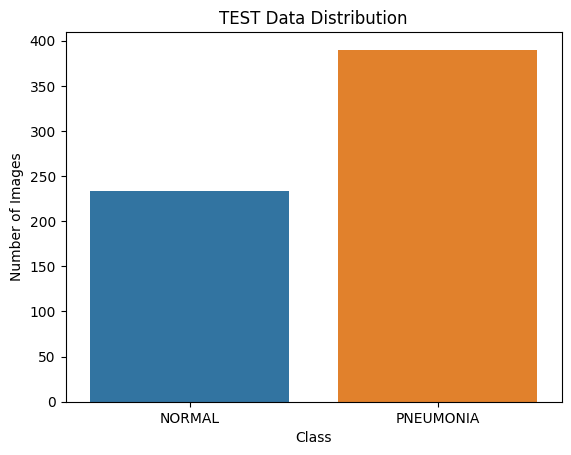

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


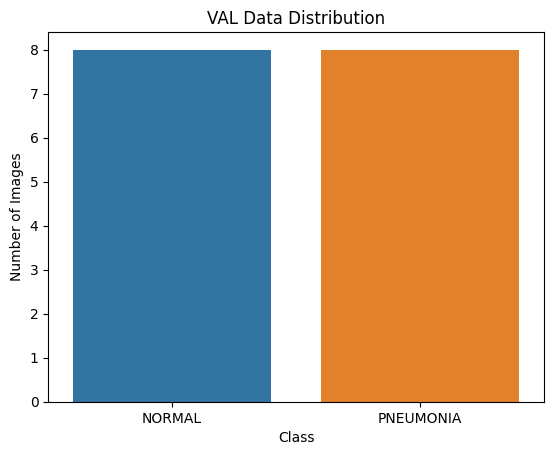

In [6]:
# Plotting
for split in splits:
    sns.barplot(x=list(data_distribution[split].keys()),
                y=list(data_distribution[split].values()))
    plt.title(f'{split.upper()} Data Distribution')
    plt.ylabel("Number of Images")
    plt.xlabel("Class")
    plt.show()

## Preprocessing and Data Augmentation (Train Set Only)
To prepare the training data, we apply the following preprocessing steps:
- Convert to grayscale
- Resize to uniform dimensions
- Normalize pixel values to the range [0, 1]

To address class imbalance and improve generalization, we also apply data augmentation:
- Random rotation
- Horizontal flipping
- Width shift
- Height shift

In [17]:
BATCH_SIZE = 32
IMG_SIZE = 180
def prepare_dataset(directory, augment=False, shuffle=True):
    ds = tf.keras.utils.image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode='binary',
        color_mode='grayscale',
        batch_size=BATCH_SIZE,
        image_size=(IMG_SIZE, IMG_SIZE),
        shuffle=shuffle
    )

    if augment:
        data_augmentation = tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.05),
            tf.keras.layers.RandomZoom(0.1),
            tf.keras.layers.RandomTranslation(0.1, 0.1)
        ])
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=tf.data.AUTOTUNE)

    normalization_layer = tf.keras.layers.Rescaling(1./256)
    ds = ds.map(lambda x, y: (normalization_layer(x), y),
                num_parallel_calls=tf.data.AUTOTUNE)

    return ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
# Prepare datasets
train_ds = prepare_dataset(os.path.join(data_dir, 'train'), augment=True)
val_ds = prepare_dataset(os.path.join(data_dir, 'val'), shuffle=False)
test_ds = prepare_dataset(os.path.join(data_dir, 'test'), shuffle=False)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


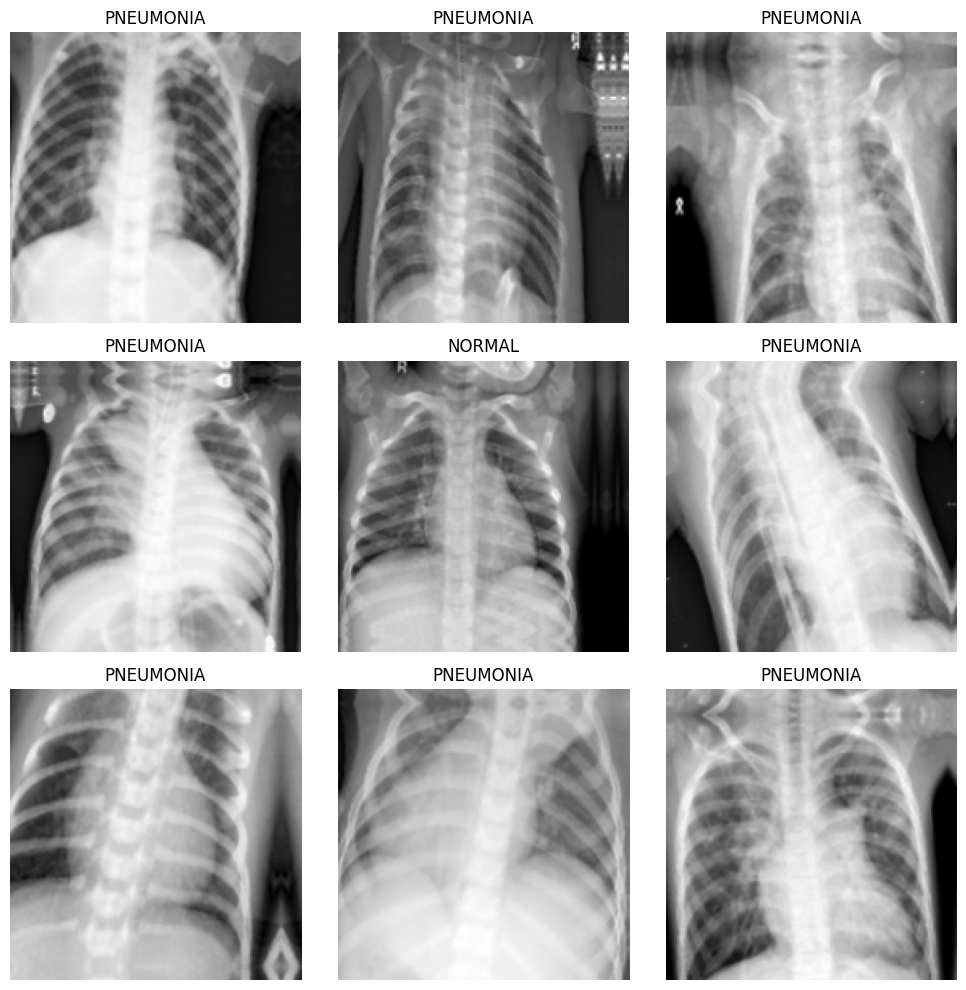

In [20]:
def show_batch(dataset):
    images, labels = next(iter(dataset))
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap="gray")
        plt.title("PNEUMONIA" if labels[i].numpy() else "NORMAL")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_batch(train_ds)

### CNN Model Function (Parameterized by Kernel Size)

This function defines a Convolutional Neural Network (CNN) model with a parameterized kernel size, which can be adjusted for experimentation. The function also allows for the input shape to be customized.

- **kernel_size**: This parameter specifies the size of the convolutional filters. By default, it is set to (3, 3).
- **input_shape**: The input shape for the model, defaulting to (180, 180, 1), suitable for grayscale images of size 180x180.
- The model consists of three convolutional layers, each followed by batch normalization and max-pooling to extract features from the images.
- The model includes a dense layer with 128 units and a dropout rate of 0.5 to prevent overfitting.
- The final output layer has a single neuron with a sigmoid activation function, making the model suitable for binary classification.
- The model is compiled with the Adam optimizer, binary cross-entropy loss, and metrics for accuracy, precision, and recall.

In [21]:
def build_cnn_model(kernel_size=(3, 3), input_shape=(180, 180, 1)):
    model = models.Sequential([
        layers.Input(shape=input_shape),  # Explicitly define input shape

        # Convolutional Layer 1
        layers.Conv2D(32, kernel_size, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),

        # Convolutional Layer 2
        layers.Conv2D(64, kernel_size, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),

        # Convolutional Layer 3
        layers.Conv2D(128, kernel_size, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', metrics.Precision(), metrics.Recall()]
    )

    return model

### Training Loop for CNN Models (with Different Kernel Sizes)

This code snippet provides a training loop to train three CNN models with varying kernel sizes. The models are parameterized by kernel size and their respective weights for the ensemble method.

- **Directory Setup**: A directory (`/kaggle/working/cnn_models`) is created to save the trained models if it doesn't already exist.
- **Models Configuration**: 
  - The models are configured with three different kernel sizes: (3, 3), (5, 5), and (7, 7), with corresponding weights (0.3, 0.6, and 0.1) and thresholds for prediction.
  
- **Training Process**: 
  - For each model, the CNN is built using the specified kernel size, then trained for 10 epochs using a training dataset (`train_ds`), with validation on `val_ds`.
  
- **Performance Metrics**: 
  - F1 scores for both validation and test datasets are calculated and stored. The threshold for prediction is applied to convert probabilities to binary values (0 or 1).
  - After training, the F1 scores for both the validation and test datasets are printed.

- **Model Saving**: 
  - The trained model is saved at the specified directory, and its file name includes the kernel size.
  
- **Classification Report**: 
  - After training each model, a classification report is generated for the test dataset, displaying precision, recall, and F1 score for each class ('NORMAL' and 'PNEUMONIA').
  
This approach helps evaluate different kernel configurations and compares the performance of each model on the same dataset.


In [22]:
# Create directory to save models if it doesn't exist
save_dir = "/kaggle/working/cnn_models"
os.makedirs(save_dir, exist_ok=True)

models_dict = {
    '3x3': {'kernel': (3, 3), 'weight': 0.3, 'threshold': 0.875},
    '5x5': {'kernel': (5, 5), 'weight': 0.6, 'threshold': 0.35},
    '7x7': {'kernel': (7, 7), 'weight': 0.1, 'threshold': 0.25}
}

trained_models = {}
history_dict = {}

# Loop for training models
for name, config in models_dict.items():
    print(f"\nTraining model with {name} kernel...")
    
    # Build the CNN model with the given kernel size
    model = build_cnn_model(kernel_size=config['kernel'])
    
    # Train the model using the training dataset
    history = model.fit(
        train_ds,
        epochs=10,
        validation_data=val_ds,
    )
    
    # Initialize lists to hold F1 scores for validation and test data
    f1_scores_val = []
    f1_scores_test = []

    # Validation F1 Score calculation
    val_true = np.concatenate([y for x, y in val_ds], axis=0)
    val_pred_prob = model.predict(val_ds)
    val_pred = (val_pred_prob > config['threshold']).astype(int)
    f1_val = f1_score(val_true, val_pred)
    f1_scores_val.append(f1_val)
    print(f"F1 Score (Validation): {f1_val:.4f}")

    # Test F1 Score calculation after training
    test_true = np.concatenate([y for x, y in test_ds], axis=0)
    test_pred_prob = model.predict(test_ds)
    test_pred = (test_pred_prob > config['threshold']).astype(int)
    f1_test = f1_score(test_true, test_pred)
    f1_scores_test.append(f1_test)
    print(f"F1 Score (Test): {f1_test:.4f}")
    
    # Store F1 scores and training history
    history_dict[name] = {
        'history': history.history,
        'f1_scores_val': f1_scores_val,
        'f1_scores_test': f1_scores_test
    }

    # Store the trained model
    trained_models[name] = model

    # Save model to disk
    model_path = os.path.join(save_dir, f"cnn_model_{name}.h5")
    model.save(model_path)
    print(f"Model saved at: {model_path}")

    # Classification report for test data
    print(f"\nClassification Report for {name} model:")
    print(classification_report(test_true, test_pred, target_names=['NORMAL', 'PNEUMONIA']))


Training model with 3x3 kernel...
Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 30s 132ms/step - accuracy: 0.8124 - loss: 1.7382 - precision_6: 0.8686 - recall_6: 0.8782 - val_accuracy: 0.5000 - val_loss: 62.4901 - val_precision_6: 0.5000 - val_recall_6: 1.0000
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.8577 - loss: 0.3140 - precision_6: 0.8897 - recall_6: 0.9218 - val_accuracy: 0.5000 - val_loss: 78.5409 - val_precision_6: 0.5000 - val_recall_6: 1.0000
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.8708 - loss: 0.2667 - precision_6: 0.8901 - recall_6: 0.9425 - val_accuracy: 0.5000 - val_loss: 10.1325 - val_precision_6: 0.5000 - val_recall_6: 1.0000
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9109 - loss: 0.2604 - precision_6: 0.9461 - recall_6: 0.9328 - val_accuracy: 0.7500 - val_loss: 0.4258 - val_precision_6: 0.6667 - val_recall_6: 1.0000
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9234 - loss: 0.21

### Plotting Evaluation Metrics

The function `plot_metrics` visualizes the performance of the CNN models over training epochs and compares evaluation metrics. It generates plots for both the accuracy/loss over epochs and F1 scores for validation and test sets.

- **Metrics to Plot**: 
  - The function first generates plots for the **accuracy** and **loss** metrics. For each metric, it plots the values for each model across all epochs and saves them as PNG images.

- **F1 Score Plot**: 
  - After plotting accuracy and loss, the function visualizes the **F1 scores** for both validation and test datasets. It creates a scatter plot where:
    - Each model's validation F1 score is marked with an **'o'** (circle).
    - Each model's test F1 score is marked with an **'x'** (cross).
  - This plot uses different colors for each model to distinguish them.

- **Plot Saving**: 
  - Each plot is saved with a high resolution of 300 DPI in the `plots` directory.
  
This function provides an overview of how each model performs over training epochs and compares their F1 scores for both validation and test datasets, helping in model selection.


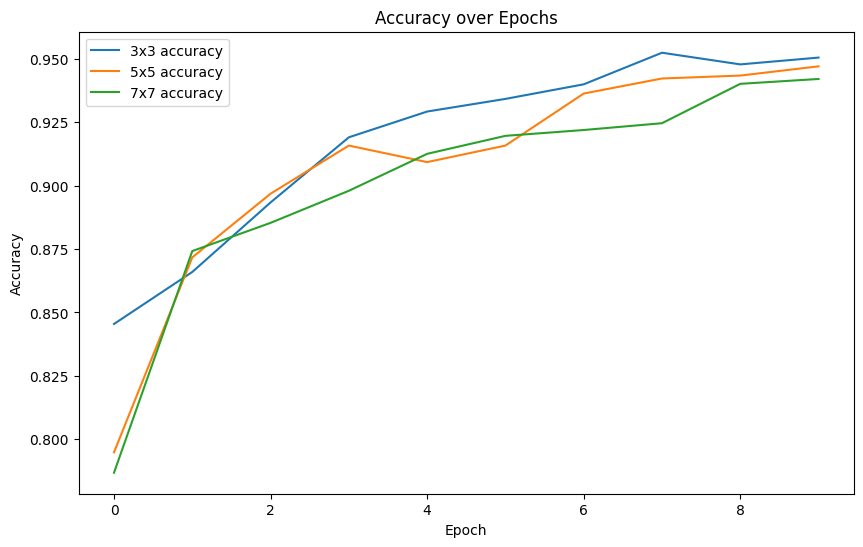

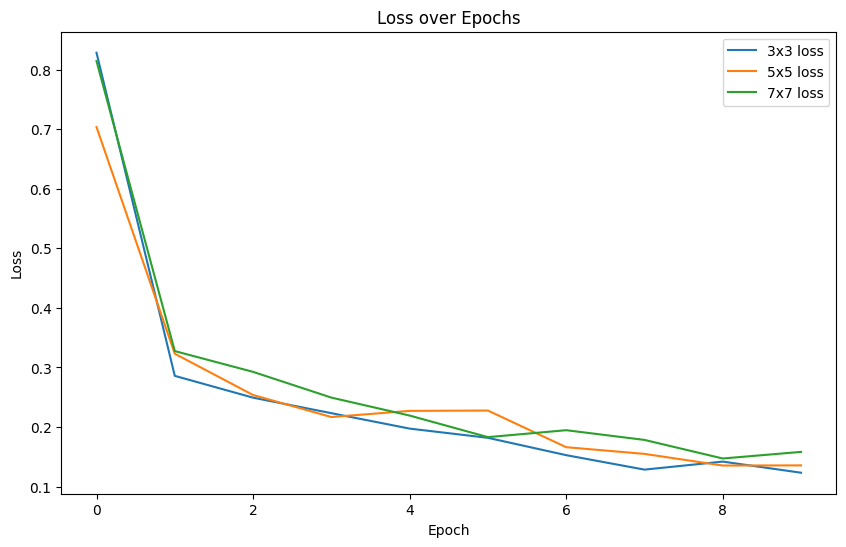

/tmp/ipykernel_31/2959488181.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab10', len(history_dict))


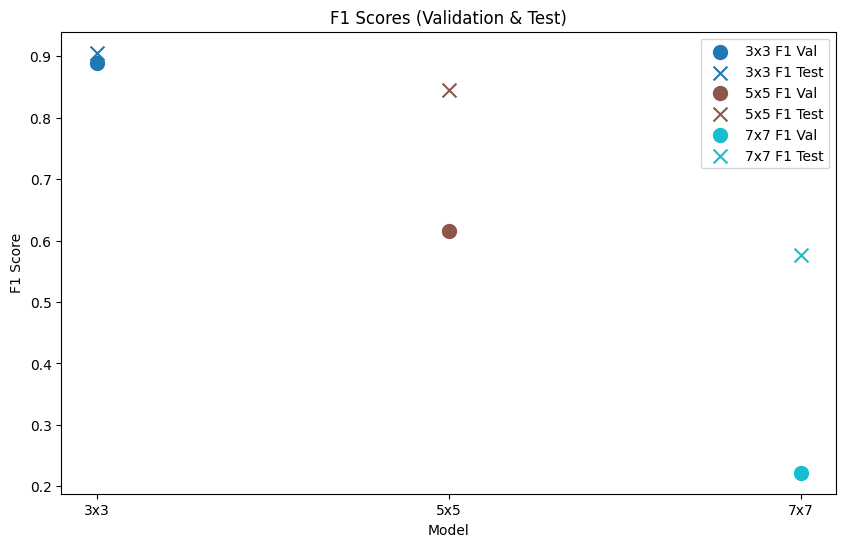

In [40]:
def plot_metrics(history_dict, save_dir='plots'):
    os.makedirs(save_dir, exist_ok=True)
    metrics = ['accuracy', 'loss']
    
    for metric in metrics:
        plt.figure(figsize=(10, 6))
        for name, data in history_dict.items():
            values = data['history'][metric]
            plt.plot(values, label=f'{name} {metric}')
        plt.title(f'{metric.capitalize()} over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.savefig(f"{save_dir}/{metric}_plot.png", dpi=300)
        plt.show()
        plt.close()
        
    colors = cm.get_cmap('tab10', len(history_dict))
    
    plt.figure(figsize=(10, 6))
    for idx, (name, data) in enumerate(history_dict.items()):
        color = colors(idx)
        plt.scatter(name, data['f1_scores_val'], label=f'{name} F1 Val', color=color, marker='o', s=100)
        plt.scatter(name, data['f1_scores_test'], label=f'{name} F1 Test', color=color, marker='x', s=100)
    
    plt.title('F1 Scores (Validation & Test)')
    plt.xlabel('Model')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.savefig(f"{save_dir}/f1_scores_plot.png", dpi=300)
    plt.show()
    plt.close()

# Call the function
plot_metrics(history_dict)

### Ensemble Model

The ensemble model combines predictions from multiple models (with different kernel sizes) and assigns weights to each model's predictions. The following steps outline the implementation:

1. **Model Paths and Weights**:
   - Paths to the pre-trained models (`cnn_model_3x3.h5`, `cnn_model_5x5.h5`, `cnn_model_7x7.h5`) are defined in the `model_paths` dictionary.
   - The weights for each model (3x3, 5x5, and 7x7) are set in the `weights` dictionary, which determines how much influence each model has on the final ensemble prediction.

2. **Loading Models**:
   - All models are loaded using `tf.keras.models.load_model` from the specified paths and stored in the `models` dictionary.

3. **Weighted Prediction Function**:
   - The `get_weighted_preds_and_labels` function is used to compute predictions from the ensemble of models.
   - The function aggregates the predictions from each model, applying the predefined weights, and generates the final ensemble prediction using a threshold.

4. **Evaluation Metrics**:
   - The ensemble model's performance is evaluated using metrics like **accuracy**, **precision**, **recall**, and **F1 score**. These metrics are calculated using the true labels (`y_true`) and the predicted labels (`y_pred`).

5. **Printing and Saving Metrics**:
   - The computed metrics are printed for easy interpretation.
   - The ensemble model's evaluation metrics are saved to a file (`ensemble_metrics.pkl`) for future use or reporting.

This process allows for a weighted combination of the predictions from different models, leading to potentially improved performance compared to individual models.


In [41]:
# Define model paths
model_paths = {
    '3x3': '/kaggle/working/cnn_models/cnn_model_3x3.h5',
    '5x5': '/kaggle/working/cnn_models/cnn_model_5x5.h5',
    '7x7': '/kaggle/working/cnn_models/cnn_model_7x7.h5'
}

# Define weights
weights = {
    '3x3': 0.3,
    '5x5': 0.6,
    '7x7': 0.1
}

# Load models
models = {key: tf.keras.models.load_model(path) for key, path in model_paths.items()}

# Function to predict with weighted ensemble
def get_weighted_preds_and_labels(ds, weights, threshold=0.5):
    y_true = np.concatenate([y for _, y in ds], axis=0)

    weighted_sum = 0
    for key, model in models.items():
        preds = model.predict(ds, verbose=0)
        weighted_sum += weights[key] * preds

    y_pred = (weighted_sum > threshold).astype(int)
    return y_true, y_pred

# Predict using test_ds
y_true, y_pred = get_weighted_preds_and_labels(test_ds, weights)

# Compute evaluation metrics
ensemble_metrics = {
    'accuracy': accuracy_score(y_true, y_pred),
    'precision': precision_score(y_true, y_pred),
    'recall': recall_score(y_true, y_pred),
    'f1_score': f1_score(y_true, y_pred)
}

# Print metrics
print("Weighted Ensemble Evaluation Metrics:")
for key, val in ensemble_metrics.items():
    print(f"{key.capitalize():<10}: {val:.4f}")

# Save metrics
with open('/kaggle/working/ensemble_metrics.pkl', 'wb') as f:
    pickle.dump(ensemble_metrics, f)

Weighted Ensemble Evaluation Metrics:
Accuracy  : 0.8365
Precision : 0.9311
Recall    : 0.7974
F1_score  : 0.8591


### Saving Model Training History

To save the model training history for later use or analysis, we use the `pickle` module. The training history, including metrics such as loss and accuracy, is stored in the `history_dict`. This dictionary is then serialized and saved to a `.pkl` file for future access.

- **Saving History**: 
  - The `history_dict` is dumped into a file named `history_dict.pkl`, allowing you to reload it later for evaluation, plotting, or comparison of different models.
  
- **Archiving Project Files**: 
  - The entire project folder (including model files, training history, and other relevant files) is compressed into a `.zip` archive (`ann_project.zip`). This makes it easy to download, share, or store the project for future use.

This process ensures that both the training results and project files are preserved efficiently.


In [30]:
with open('history_dict.pkl', 'wb') as f:
    pickle.dump(history_dict, f)

In [45]:
!zip -r /kaggle/working/ann_project.zip /kaggle/working/*

updating: kaggle/working/cnn_models/ (stored 0%)
updating: kaggle/working/cnn_models/cnn_model_5x5.h5 (deflated 12%)
updating: kaggle/working/cnn_models/cnn_model_7x7.h5 (deflated 7%)
updating: kaggle/working/cnn_models/cnn_model_3x3.h5 (deflated 8%)
updating: kaggle/working/history_dict.pkl (deflated 58%)
updating: kaggle/working/plots/ (stored 0%)
updating: kaggle/working/plots/f1_scores_plot.png (deflated 27%)
updating: kaggle/working/plots/loss_plot.png (deflated 19%)
updating: kaggle/working/plots/accuracy_plot.png (deflated 16%)
  adding: kaggle/working/ensemble_metrics.pkl (deflated 18%)
  adding: kaggle/working/plots/ensemble_confusion_matrix.png (deflated 16%)


<h2 align="center">Thank you :)</h2>